# WorldFloods Dataset

This notebook will be exploring the WorldFloods dataset and what data we have available. In particular, we are looking the Sentinel-2 Dataset and the associated ground truth available. In one particular application (cite), they used this data to predict flood extent. More details can be found (here).

#### Load Packages

In [1]:
# Helpful trick for loading the directories correction
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Open File

In [2]:
from pathlib import Path

In [3]:
gs_index = "gs://"
bucket_id = "ml4floods"
path = "worldfloods/public/"
sub_dir = "train/S2"
file_name = "01042016_Holmes_Creek_at_Vernon_FL.tif"


full_path = gs_index + str(Path(bucket_id).joinpath(path).joinpath(sub_dir).joinpath(file_name))
print(full_path)


gs://ml4floods/worldfloods/public/train/S2/01042016_Holmes_Creek_at_Vernon_FL.tif


### Substep 1: Check File Exists

In [4]:

def check_file_in_bucket_exists(bucket_name: str, filename: str, **kwargs) -> bool:
    # initialize client
    client = storage.Client(**kwargs)
    # get bucket
    bucket = client.get_bucket(bucket_name)
    # get blob
    blob = bucket.blob(filename)
    # check if it exists
    return blob.exists()



### SubStep 2: Extract Metadata

In [7]:
from google.cloud import storage

client = storage.Client()

file_name = "worldfloods/public/train/meta/01042016_Choctawhatchee_River_near_Bellwood_AL.json"
bucket_id = "ml4floods"

# check to see if file exists
verdict = check_file_in_bucket_exists(bucket_id, file_name)
print(verdict)

True


## SubStep 3: Initialize DataClass


**IDEAS FOR ATTRIBUTES**

**Essential MetaData**

* uri
* filepath
* bucket_id
* product_id

**BreadCrumbs**

* load_date
* viewed_by
* source_system

**Extras**

* cloudy_pixel_percentage
* spacecraft_name
* system_time_start
* geometry_coordinates
* number of bands
* extra meta-data

In [30]:

from dataclasses import dataclass, field
from datetime import datetime
from typing import List, Dict


@dataclass
class WorldFloodsImage:
    # ESSENTIAL METADATA
    filename: str
    uri: str = field(default=None)
    filepath: str = field(default=None)
    bucket_id: str= field(default=None)
    product_id: str = field(default=None)
    
    # BREADCRUMBS
    load_date: str = field(default = datetime.now())
    viewed_by: list = field(default_factory = list, compare = False, repr = False)
    source_system: str = field(default = "Not Specified")
    

In [9]:
import json

def load_json_from_bucket(bucket_name: str, filename: str, **kwargs) -> Dict:
    # initialize client
    client = storage.Client(**kwargs)
    # get bucket
    bucket = client.get_bucket(bucket_name)
    # get blob
    blob = bucket.blob(filename)
    # check if it exists
    # TODO: wrap this within a context
    return json.loads(blob.download_as_string(client=None))


#### 3.1 - Open JSON FIle

In [10]:
# get filename
filename = "ml4floods/worldfloods/public/train/S2/01042016_Holmes_Creek_at_Vernon_FL.tif"
prefix =  "worldfloods/public/train/meta/01042016_Choctawhatchee_River_near_Bellwood_AL.json"
bucket_id = "ml4floods"

# load json file
json_info = load_json_from_bucket(bucket_id, prefix)

print(json_info)

{'source': 'glofimr', 'satellite': 'Landsat-8', 'satellite date': '2016-01-04T00:00:00Z', 'shape': [10086, 8742], 'pixels invalid S2': 3413143, 'pixels clouds S2': 23711, 'pixels water S2': 7084781, 'pixels land S2': 77650177, 'pixels flood water S2': 3414937, 'pixels hydro water S2': 0, 'pixels permanent water S2': 3669844, 'method clouds': 's2cloudless', 'bounds': [-86.43742377396336, 30.3493123793928, -85.65211655258608, 31.255353174955747], 's2metadata': [{'date_string': '2016-01-11 16:37', 'system:time_start': 1452530233424, 'area_rel': 100}]}


#### 3.2 - Parse Relevant Information

In [11]:
dc_example = WorldFloodsImage(filename=filename)

print(dc_example)

WorldFloodsImage(filename='ml4floods/worldfloods/public/train/S2/01042016_Holmes_Creek_at_Vernon_FL.tif', uri=None, filepath=None, bucket_id=None, product_id=None, load_date=datetime.datetime(2021, 2, 17, 18, 35, 57, 440289), source_system='Not Specified')


#### Check Corresponding File Exists

It could be that the meta-data doesn't actually have any corresponding image. I find it strange that this is actually not inside of the metadata...

## 4 - Download Image

In [18]:

def get_image_path(datclass) -> str:
    """Extracts the S2 Image path

    Args: 
        ml_type (str): path to the dataset for the bucket
    Returns:
        path (str): path for the bucket
    """
    return str(Path(datclass.filename))

def download_image(datclass, destination: str) -> str:
    """Downloads the S2 Image

    Args: 
        destination (str): path to where we want to save the data
        ml_type (str): path to the dataset for the bucket
    Returns:
        None
    """
    # get image path
    img_path = get_image_path(datclass)
    
    # download the image
    return download_data_from_bucket([img_path], destination)

In [19]:
from src.data.utils import download_data_from_bucket

# get image filename
get_image_path(dc_example)

# demo 2 - download the image from the bucket
# destination directory
destination_dir = Path(root).joinpath("datasets/trials/image")
download_image(dc_example, destination_dir)

Folder '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image' Is Already There.


## 5 - Visualize the Image

In [27]:
import rasterio
from rasterio.plot import show as rasterio_show

def visualize_image(datclass, ax=None, )-> None:
    """Preview the Demo Data

    Args: 
        destination (str): path to where we want to save the data
        ml_type (str): path to the dataset for the bucket
    Returns:
        None
    """
    # Display
    if ax is None:
        fig, ax = plt.subplots()
    with rasterio.open("gs://" + get_image_path(datclass)) as f:
        rasterio_show(f.read(1), ax=ax, cmap="pink")

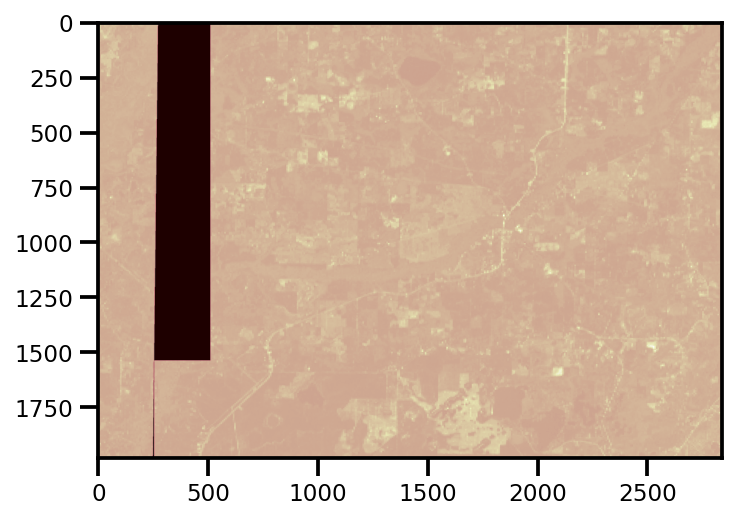

In [28]:
fig, ax = plt.subplots()

visualize_image(dc_example, ax=ax)
plt.show()

#### Ground Truth Image

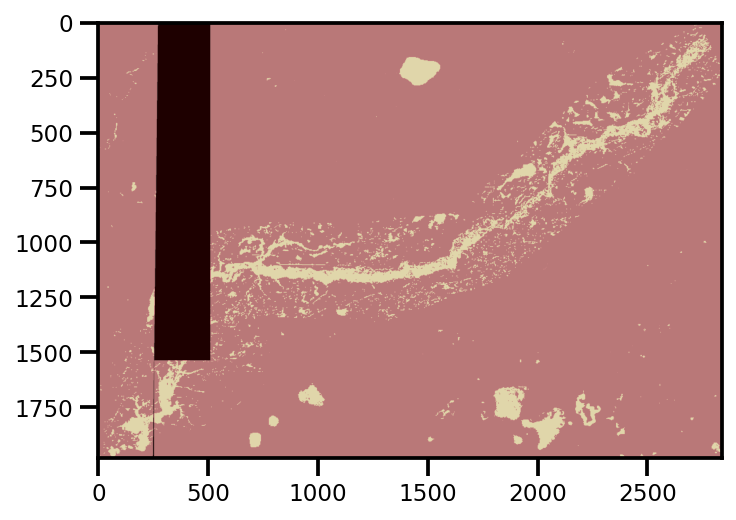

In [31]:
# get filename
filename = "ml4floods/worldfloods/public/train/gt/01042016_Holmes_Creek_at_Vernon_FL.tif"

dc_example = WorldFloodsImage(filename=filename)


fig, ax = plt.subplots()

visualize_image(dc_example, ax=ax)
plt.show()